In [ ]:
# prompt: code to link to drive

from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Check the GPU type

!nvidia-smi

Sun Mar  3 12:59:27 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   70C    P8              11W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
import torch
from torch import nn

# Note: this notebook requires torch >= 1.10.0
torch.__version__

'2.1.0+cu121'

In [ ]:
# Setup device-agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [ ]:
from pathlib import Path
image_path = Path("/content/drive/MyDrive/Diffusion/ForestFire")

In [ ]:
import os
def walk_through_dir(dir_path):
  """
  Walks through dir_path returning its contents.
  Args:
    dir_path (str or pathlib.Path): target directory

  Returns:
    A print out of:
      number of subdiretories in dir_path
      number of images (files) in each subdirectory
      name of each subdirectory
  """
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

In [ ]:
walk_through_dir(image_path)

There are 2 directories and 0 images in '/content/drive/MyDrive/Diffusion/ForestFire'.
There are 1 directories and 0 images in '/content/drive/MyDrive/Diffusion/ForestFire/train'.
There are 0 directories and 760 images in '/content/drive/MyDrive/Diffusion/ForestFire/train/fire'.
There are 1 directories and 0 images in '/content/drive/MyDrive/Diffusion/ForestFire/test'.
There are 0 directories and 190 images in '/content/drive/MyDrive/Diffusion/ForestFire/test/fire'.


In [ ]:
# Setup train and testing paths
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(PosixPath('/content/drive/MyDrive/Diffusion/ForestFire/train'),
 PosixPath('/content/drive/MyDrive/Diffusion/ForestFire/test'))

Random image path: /content/drive/MyDrive/Diffusion/ForestFire/train/fire/fire_0354.jpg
Image class: fire
Image height: 250
Image width: 250


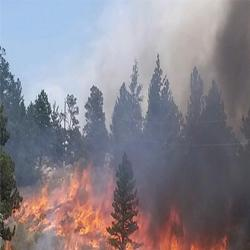

In [ ]:
import random
from PIL import Image

# Set seed
random.seed(36) # <- try changing this and see what happens

# 1. Get all image paths (* means "any combination")
image_path_list = list(image_path.glob("*/*/*.jpg"))

# 2. Get random image path
random_image_path = random.choice(image_path_list)

# 3. Get image class from path name (the image class is the name of the directory where the image is stored)
image_class = random_image_path.parent.stem

# 4. Open image
img = Image.open(random_image_path)

# 5. Print metadata
print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}")
print(f"Image width: {img.width}")
img

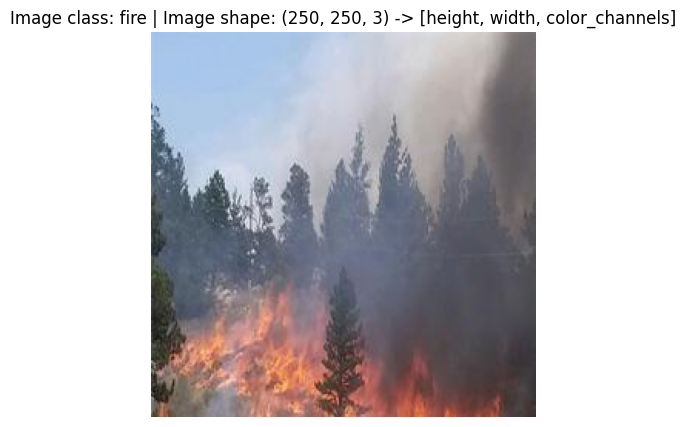

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Turn the image into an array
img_as_array = np.asarray(img)

# Plot the image with matplotlib
plt.figure(figsize=(5, 5))
plt.imshow(img_as_array)
plt.title(f"Image class: {image_class} | Image shape: {img_as_array.shape} -> [height, width, color_channels]")
plt.axis(False);

In [ ]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import save_image
import os

In [ ]:
def plot_transformed_images(image_paths, transform, n=3, seed=36):
    """Plots a series of random images from image_paths.

    Will open n image paths from image_paths, transform them
    with transform and plot them side by side.

    Args:
        image_paths (list): List of target image paths.
        transform (PyTorch Transforms): Transforms to apply to images.
        n (int, optional): Number of images to plot. Defaults to 3.
        seed (int, optional): Random seed for the random generator. Defaults to 42.
    """
    random.seed(seed)
    random_image_paths = random.sample(image_paths, k=n)
    for image_path in random_image_paths:
        with Image.open(image_path) as f:
            fig, ax = plt.subplots(1, 2)
            ax[0].imshow(f)
            ax[0].set_title(f"Original \nSize: {f.size}")
            ax[0].axis("off")
            # print('orig_image')
            # print(f)
            # Transform and plot image
            # Note: permute() will change shape of image to suit matplotlib
            # (PyTorch default is [C, H, W] but Matplotlib is [H, W, C])
            transformed_image = transform(f).permute(1, 2, 0)
            ax[1].imshow(transformed_image)
            ax[1].set_title(f"Transformed \nSize: {transformed_image.shape}")
            ax[1].axis("off")
            # print('transformed_image')
            # print(transformed_image)
            fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)



Train data:
Dataset ImageFolder
    Number of datapoints: 760
    Root location: /content/drive/MyDrive/Diffusion/ForestFire/train
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
               ToTensor()
               Normalize(mean=[0.5], std=[0.5])
           )
Test data:
Dataset ImageFolder
    Number of datapoints: 190
    Root location: /content/drive/MyDrive/Diffusion/ForestFire/test
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
               ToTensor()
               Normalize(mean=[0.5], std=[0.5])
           )


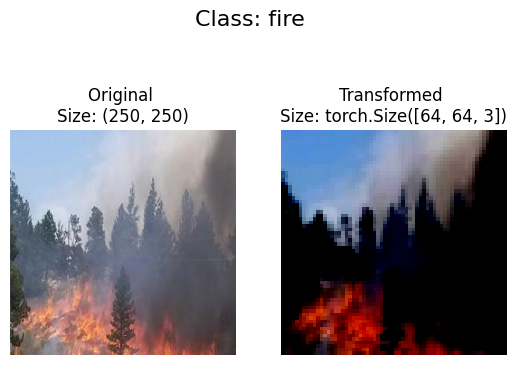

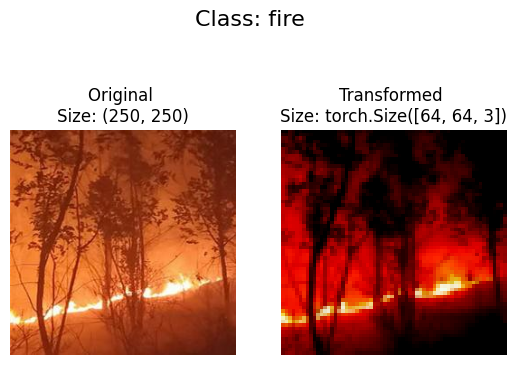

In [ ]:


# Use ImageFolder to create dataset(s)

# Write transform for image
data_transform = transforms.Compose([
    # Resize the images to 64x64
    transforms.Resize(size=(64, 64)),
    # Turn the image into a torch.Tensor
    transforms.ToTensor(), # this also converts all pixel values from 0 to 255 to be between 0.0 and 1.0
    transforms.Normalize([0.5], [0.5])
])

plot_transformed_images(image_path_list,
                        transform=data_transform,
                        n=2)

from torchvision import datasets
train_data = datasets.ImageFolder(root=train_dir, # target folder of images
                                  transform=data_transform, # transforms to perform on data (images)
                                  target_transform=None) # transforms to perform on labels (if necessary)

test_data = datasets.ImageFolder(root=test_dir,
                                 transform=data_transform)

print(f"Train data:\n{train_data}\nTest data:\n{test_data}")

In [ ]:
# Get class names as a list
class_names = train_data.classes
class_names

['fire']

In [ ]:
# Can also get class names as a dict
class_dict = train_data.class_to_idx
class_dict

{'fire': 0}

In [ ]:
# Check the lengths
len(train_data), len(test_data)

(760, 190)

In [ ]:
img, label = train_data[0][0], train_data[0][1]
print(f"Image tensor:\n{img}")
print(f"Image shape: {img.shape}")
print(f"Image datatype: {img.dtype}")
print(f"Image label: {label}")
print(f"Label datatype: {type(label)}")

Image tensor:
tensor([[[-0.6549, -0.5216, -0.5059,  ..., -0.7882, -0.8039, -0.8196],
         [-0.5294, -0.3804, -0.3647,  ..., -0.7490, -0.7647, -0.7725],
         [-0.5373, -0.3961, -0.3961,  ..., -0.7490, -0.7569, -0.7725],
         ...,
         [-0.7569, -0.8196, -0.7882,  ..., -0.7020, -0.7098, -0.7176],
         [-0.8902, -0.8745, -0.8275,  ..., -0.7255, -0.7412, -0.7255],
         [-0.9059, -0.8824, -0.8353,  ..., -0.7098, -0.7333, -0.7176]],

        [[-0.7804, -0.7490, -0.7333,  ..., -0.8980, -0.9137, -0.9137],
         [-0.7412, -0.6941, -0.6706,  ..., -0.8980, -0.9137, -0.9059],
         [-0.7255, -0.6863, -0.6627,  ..., -0.9059, -0.9059, -0.9059],
         ...,
         [-0.8353, -0.8980, -0.9216,  ..., -0.8510, -0.8667, -0.8667],
         [-0.9294, -0.9294, -0.9608,  ..., -0.8824, -0.8980, -0.8824],
         [-0.9373, -0.9373, -0.9608,  ..., -0.8667, -0.8902, -0.8745]],

        [[-0.8588, -0.8824, -0.8510,  ..., -0.8588, -0.8667, -0.8667],
         [-0.8902, -0.9373, -0.

Original shape: torch.Size([3, 64, 64]) -> [color_channels, height, width]
Image permute shape: torch.Size([64, 64, 3]) -> [height, width, color_channels]


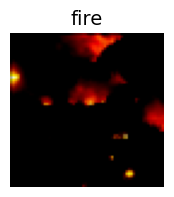

In [ ]:
# Rearrange the order of dimensions
img_permute = img.permute(1, 2, 0)

# Print out different shapes (before and after permute)
print(f"Original shape: {img.shape} -> [color_channels, height, width]")
print(f"Image permute shape: {img_permute.shape} -> [height, width, color_channels]")

# Plot the image
plt.figure(figsize=(2, 2))
plt.imshow(img.permute(1, 2, 0))
plt.axis("off")
plt.title(class_names[label], fontsize=14);

In [ ]:
# Imports

from contextlib import contextmanager
from copy import deepcopy
import math

from IPython import display
from matplotlib import pyplot as plt
import torch
from torch import optim, nn
from torch.nn import functional as F
from torch.utils import data
from torchvision import datasets, transforms, utils
from torchvision.transforms import functional as TF
from tqdm.notebook import tqdm, trange


In [ ]:
# Utilities

@contextmanager
def train_mode(model, mode=True):
    """A context manager that places a model into training mode and restores
    the previous mode on exit."""
    modes = [module.training for module in model.modules()]
    try:
        yield model.train(mode)
    finally:
        for i, module in enumerate(model.modules()):
            module.training = modes[i]


def eval_mode(model):
    """A context manager that places a model into evaluation mode and restores
    the previous mode on exit."""
    return train_mode(model, False)


@torch.no_grad()
def ema_update(model, averaged_model, decay):
    """Incorporates updated model parameters into an exponential moving averaged
    version of a model. It should be called after each optimizer step."""
    model_params = dict(model.named_parameters())
    averaged_params = dict(averaged_model.named_parameters())
    assert model_params.keys() == averaged_params.keys()

    for name, param in model_params.items():
        averaged_params[name].mul_(decay).add_(param, alpha=1 - decay)

    model_buffers = dict(model.named_buffers())
    averaged_buffers = dict(averaged_model.named_buffers())
    assert model_buffers.keys() == averaged_buffers.keys()

    for name, buf in model_buffers.items():
        averaged_buffers[name].copy_(buf)


In [ ]:
# Define the model (a residual U-Net)

class ResidualBlock(nn.Module):
    def __init__(self, main, skip=None):
        super().__init__()
        self.main = nn.Sequential(*main)
        self.skip = skip if skip else nn.Identity()

    def forward(self, input):
        return self.main(input) + self.skip(input)


class ResConvBlock(ResidualBlock):
    def __init__(self, c_in, c_mid, c_out, is_last=False):
        skip = None if c_in == c_out else nn.Conv2d(c_in, c_out, 1, bias=False)
        super().__init__([
            nn.Conv2d(c_in, c_mid, 3, padding=1),
            nn.Dropout2d(0.1, inplace=True),
            nn.ReLU(inplace=True),
            nn.Conv2d(c_mid, c_out, 3, padding=1),
            nn.Dropout2d(0.1, inplace=True) if not is_last else nn.Identity(),
            nn.ReLU(inplace=True) if not is_last else nn.Identity(),
        ], skip)


class SelfAttention2d(nn.Module):
    def __init__(self, c_in, n_head=1, dropout_rate=0.1):
        super().__init__()
        assert c_in % n_head == 0
        self.norm = nn.GroupNorm(1, c_in)
        self.n_head = n_head
        self.qkv_proj = nn.Conv2d(c_in, c_in * 3, 1)
        self.out_proj = nn.Conv2d(c_in, c_in, 1)
        self.dropout = nn.Dropout2d(dropout_rate, inplace=True)

    def forward(self, input):
        n, c, h, w = input.shape
        qkv = self.qkv_proj(self.norm(input))
        qkv = qkv.view([n, self.n_head * 3, c // self.n_head, h * w]).transpose(2, 3)
        q, k, v = qkv.chunk(3, dim=1)
        scale = k.shape[3]**-0.25
        att = ((q * scale) @ (k.transpose(2, 3) * scale)).softmax(3)
        y = (att @ v).transpose(2, 3).contiguous().view([n, c, h, w])
        return input + self.dropout(self.out_proj(y))


class SkipBlock(nn.Module):
    def __init__(self, main, skip=None):
        super().__init__()
        self.main = nn.Sequential(*main)
        self.skip = skip if skip else nn.Identity()

    def forward(self, input):
        return torch.cat([self.main(input), self.skip(input)], dim=1)


class FourierFeatures(nn.Module):
    def __init__(self, in_features, out_features, std=1.):
        super().__init__()
        assert out_features % 2 == 0
        self.weight = nn.Parameter(torch.randn([out_features // 2, in_features]) * std)

    def forward(self, input):
        f = 2 * math.pi * input @ self.weight.T
        return torch.cat([f.cos(), f.sin()], dim=-1)


def expand_to_planes(input, shape):
    return input[..., None, None].repeat([1, 1, shape[2], shape[3]])


class Diffusion(nn.Module):
    def __init__(self):
        super().__init__()
        c = 64  # The base channel count

        self.timestep_embed = FourierFeatures(1, 16)
        self.class_embed = nn.Embedding(11, 4)

        self.net = nn.Sequential(   # 32x32
            ResConvBlock(3 + 16 + 4, c, c),
            ResConvBlock(c, c, c),
            SkipBlock([
                nn.AvgPool2d(2),  # 32x32 -> 16x16
                ResConvBlock(c, c * 2, c * 2),
                ResConvBlock(c * 2, c * 2, c * 2),
                SkipBlock([
                    nn.AvgPool2d(2),  # 16x16 -> 8x8
                    ResConvBlock(c * 2, c * 4, c * 4),
                    SelfAttention2d(c * 4, c * 4 // 64),
                    ResConvBlock(c * 4, c * 4, c * 4),
                    SelfAttention2d(c * 4, c * 4 // 64),
                    SkipBlock([
                        nn.AvgPool2d(2),  # 8x8 -> 4x4
                        ResConvBlock(c * 4, c * 8, c * 8),
                        SelfAttention2d(c * 8, c * 8 // 64),
                        ResConvBlock(c * 8, c * 8, c * 8),
                        SelfAttention2d(c * 8, c * 8 // 64),
                        ResConvBlock(c * 8, c * 8, c * 8),
                        SelfAttention2d(c * 8, c * 8 // 64),
                        ResConvBlock(c * 8, c * 8, c * 4),
                        SelfAttention2d(c * 4, c * 4 // 64),
                        nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),
                    ]),  # 4x4 -> 8x8
                    ResConvBlock(c * 8, c * 4, c * 4),
                    SelfAttention2d(c * 4, c * 4 // 64),
                    ResConvBlock(c * 4, c * 4, c * 2),
                    SelfAttention2d(c * 2, c * 2 // 64),
                    nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),
                ]),  # 8x8 -> 16x16
                ResConvBlock(c * 4, c * 2, c * 2),
                ResConvBlock(c * 2, c * 2, c),
                nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),
            ]),  # 16x16 -> 32x32
            ResConvBlock(c * 2, c, c),
            ResConvBlock(c, c, 3, is_last=True),
        )

    def forward(self, input, t, cond):
        timestep_embed = expand_to_planes(self.timestep_embed(t[:, None]), input.shape)
        class_embed = expand_to_planes(self.class_embed(cond + 1), input.shape)
        return self.net(torch.cat([input, class_embed, timestep_embed], dim=1))


In [ ]:
# Define the noise schedule and sampling loop

def get_alphas_sigmas(t):
    """Returns the scaling factors for the clean image (alpha) and for the
    noise (sigma), given a timestep."""
    return torch.cos(t * math.pi / 2), torch.sin(t * math.pi / 2)


@torch.no_grad()
def sample(model, x, steps, eta, classes, guidance_scale=1.):
    """Draws samples from a model given starting noise."""
    ts = x.new_ones([x.shape[0]])

    # Create the noise schedule
    t = torch.linspace(1, 0, steps + 1)[:-1]
    alphas, sigmas = get_alphas_sigmas(t)

    # The sampling loop
    for i in trange(steps):

        # Get the model output (v, the predicted velocity)
        with torch.cuda.amp.autocast():
            x_in = torch.cat([x, x])
            ts_in = torch.cat([ts, ts])
            classes_in = torch.cat([-torch.ones_like(classes), classes])
            v_uncond, v_cond = model(x_in, ts_in * t[i], classes_in).float().chunk(2)
        v = v_uncond + guidance_scale * (v_cond - v_uncond)

        # Predict the noise and the denoised image
        pred = x * alphas[i] - v * sigmas[i]
        eps = x * sigmas[i] + v * alphas[i]

        # If we are not on the last timestep, compute the noisy image for the
        # next timestep.
        if i < steps - 1:
            # If eta > 0, adjust the scaling factor for the predicted noise
            # downward according to the amount of additional noise to add
            ddim_sigma = eta * (sigmas[i + 1]**2 / sigmas[i]**2).sqrt() * \
                (1 - alphas[i]**2 / alphas[i + 1]**2).sqrt()
            adjusted_sigma = (sigmas[i + 1]**2 - ddim_sigma**2).sqrt()

            # Recombine the predicted noise and predicted denoised image in the
            # correct proportions for the next step
            x = pred * alphas[i + 1] + eps * adjusted_sigma

            # Add the correct amount of fresh noise
            if eta:
                x += torch.randn_like(x) * ddim_sigma

    # If we are on the last timestep, output the denoised image
    return pred


The noise schedule:


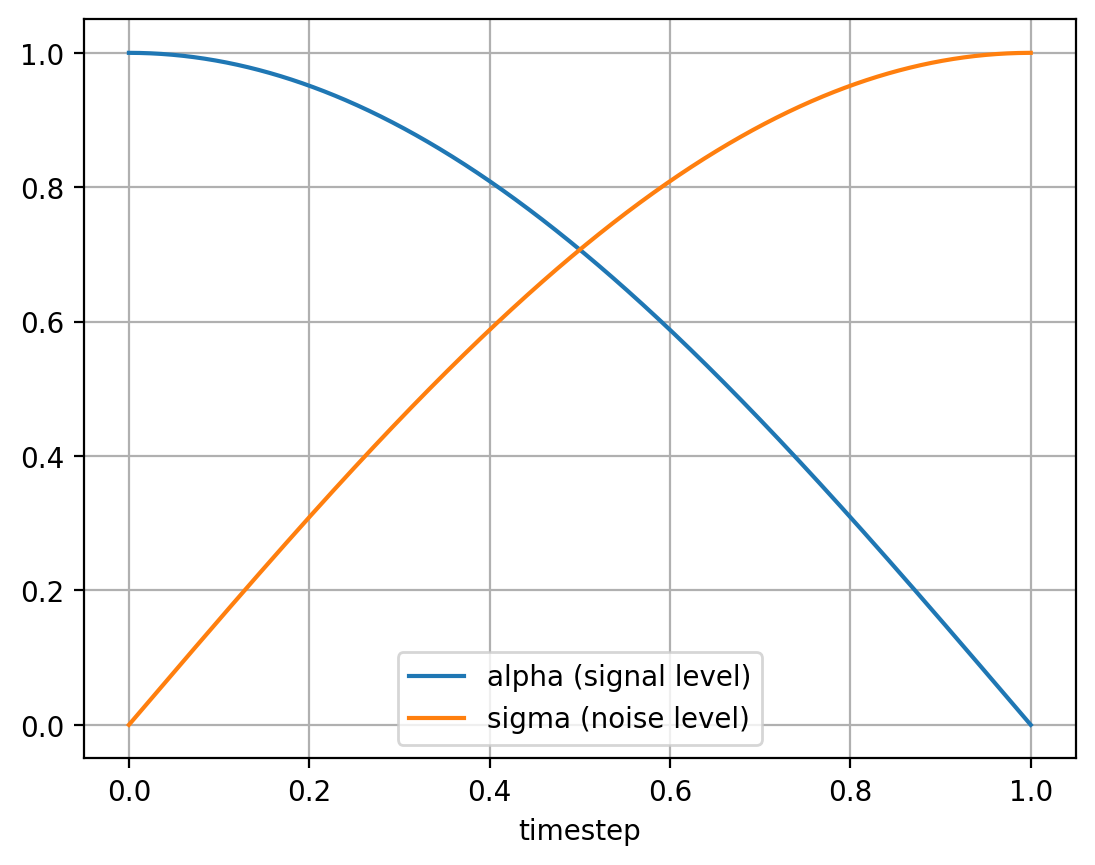

In [ ]:
# Visualize the noise schedule

%config InlineBackend.figure_format = 'retina'
plt.rcParams['figure.dpi'] = 100

t_vis = torch.linspace(0, 1, 1000)
alphas_vis, sigmas_vis = get_alphas_sigmas(t_vis)

print('The noise schedule:')

plt.plot(t_vis, alphas_vis, label='alpha (signal level)')
plt.plot(t_vis, sigmas_vis, label='sigma (noise level)')
plt.legend()
plt.xlabel('timestep')
plt.grid()
plt.show()


In [ ]:
# Prepare the dataset

batch_size = 100


train_dl = DataLoader(dataset=train_data, batch_size = batch_size, shuffle=True,
                           num_workers=4, persistent_workers=True, pin_memory=True)

val_dl = DataLoader(dataset=test_data, batch_size = batch_size,
                         num_workers=4, persistent_workers=True, pin_memory=True)


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
train_dl

In [ ]:
# Create the model and optimizer

seed = 22

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
torch.manual_seed(seed)

model = Diffusion().to(device)
model_ema = deepcopy(model)
print('Model parameters:', sum(p.numel() for p in model.parameters()))

opt = optim.Adam(model.parameters(), lr=2e-4)
scaler = torch.cuda.amp.GradScaler()
epoch = 0

# Use a low discrepancy quasi-random sequence to sample uniformly distributed
# timesteps. This considerably reduces the between-batch variance of the loss.
rng = torch.quasirandom.SobolEngine(1, scramble=True)

Using device: cuda
Model parameters: 27487287


In [ ]:
torch.arange(1, device=device).repeat_interleave(4, 0)

tensor([0, 0, 0, 0], device='cuda:0')

In [ ]:

import matplotlib.pyplot as plt

# Define an empty list to store losses
train_losses = []
val_losses = []

In [ ]:
import random

In [ ]:
# Actually train the model

ema_decay = 0.999

# The number of timesteps to use when sampling
steps = 500

# The amount of noise to add each timestep when sampling
# 0 = no noise (DDIM)
# 1 = full noise (DDPM)
eta = 1.

# Classifier-free guidance scale (0 is unconditional, 1 is conditional)
guidance_scale = 2.

def eval_loss(model, rng, reals, classes):
    # Draw uniformly distributed continuous timesteps
    t = rng.draw(reals.shape[0])[:, 0].to(device)

    # Calculate the noise schedule parameters for those timesteps
    alphas, sigmas = get_alphas_sigmas(t)

    # Combine the ground truth images and the noise
    alphas = alphas[:, None, None, None]
    sigmas = sigmas[:, None, None, None]
    noise = torch.randn_like(reals)
    noised_reals = reals * alphas + noise * sigmas
    targets = noise * alphas - reals * sigmas

    # Drop out the class on 20% of the examples
    to_drop = torch.rand(classes.shape, device=classes.device).le(0.2)
    classes_drop = torch.where(to_drop, -torch.ones_like(classes), classes)

    # Compute the model output and the loss.
    with torch.cuda.amp.autocast():
        v = model(noised_reals, t, classes_drop)
        return F.mse_loss(v, targets)


def train():
    for i, (reals, classes) in enumerate(tqdm(train_dl)):
        opt.zero_grad()
        reals = reals.to(device)
        classes = classes.to(device)

        # Evaluate the loss
        loss = eval_loss(model, rng, reals, classes)


        # Do the optimizer step and EMA update
        scaler.scale(loss).backward()
        scaler.step(opt)
        ema_update(model, model_ema, 0.95 if epoch < 20 else ema_decay)
        scaler.update()

        if i % 50 == 0:
            tqdm.write(f'Epoch: {epoch}, iteration: {i}, loss: {loss.item():g}')
            train_losses.append(loss.item())


@torch.no_grad()
@torch.random.fork_rng()
@eval_mode(model_ema)
def val():
    tqdm.write('\nValidating...')
    torch.manual_seed(seed)
    rng = torch.quasirandom.SobolEngine(1, scramble=True)
    total_loss = 0
    count = 0
    for i, (reals, classes) in enumerate(tqdm(val_dl)):
        reals = reals.to(device)
        classes = classes.to(device)

        loss = eval_loss(model_ema, rng, reals, classes)

        total_loss += loss.item() * len(reals)
        count += len(reals)
    val_losses.append(loss.item())  # Store the loss
    loss = total_loss / count

    tqdm.write(f'Validation: Epoch: {epoch}, loss: {loss:g}')


@torch.no_grad()
@torch.random.fork_rng()
@eval_mode(model_ema)
def demo():
    tqdm.write('\nSampling...')
    torch.manual_seed(seed)

    noise = torch.randn([16, 3, 64, 64], device=device)
    fakes_classes = torch.arange(1, device=device).repeat_interleave(16, 0)
    fakes = sample(model_ema, noise, steps, eta, fakes_classes, guidance_scale)

    grid = utils.make_grid(fakes, 4).cpu()
    filename = f'demo_{epoch:05}.png'
    TF.to_pil_image(grid.add(1).div(2).clamp(0, 1)).save(filename)
    display.display(display.Image(filename))
    tqdm.write('')


@torch.no_grad()
@torch.random.fork_rng()
@eval_mode(model_ema)
def generate_and_save_images():
    tqdm.write('\nSampling...')
    torch.manual_seed(seed)
    num_sample = 500
    generated_samples_m = demo_fid_samples(num_sample)
    directory = f"/content/generated_images_{epoch}/"
    if not os.path.exists(directory):
        os.makedirs(directory)

    # Loop through the batch and save each image
    for i in range(generated_samples_m.size(0)):
        # Extract one image from the batch
        image = generated_samples_m[i]
        filename = f"/content/generated_images_{epoch}/image_{i}.png"
        TF.to_pil_image(image.cpu().add(1).div(2).clamp(0, 1)).save(filename)



@torch.no_grad()
@torch.random.fork_rng()
@eval_mode(model_ema)
def demo_fid():
    tqdm.write('\nSampling...')
    torch.manual_seed(random.randint(0,10000))

    noise = torch.randn([1, 3, 64, 64], device=device)
    fakes_classes = torch.arange(1, device=device).repeat_interleave(1, 0)
    fakes = sample(model_ema, noise, steps, eta, fakes_classes, guidance_scale)
    return fakes[0]


@torch.no_grad()
@torch.random.fork_rng()
@eval_mode(model_ema)
def demo_fid_samples(num_samples):
    tqdm.write('\nSampling...')
    torch.manual_seed(random.randint(0,10000))

    noise = torch.randn([num_samples, 3, 64, 64], device=device)
    fakes_classes = torch.arange(1, device=device).repeat_interleave(num_samples, 0)
    fakes = sample(model_ema, noise, steps, eta, fakes_classes, guidance_scale)
    return fakes


# @torch.no_grad()
# @torch.random.fork_rng()
# @eval_mode(model_ema)
# def generate_and_save_images2():
#     tqdm.write('\nSampling...')
#     torch.manual_seed(seed)
#     num_sample = 500
#     generated_samples = demo_fid_samples(num_sample)
#     generated_samples_m = torch.clamp(generated_samples, 0, 1)
#     directory = f"/content/generated_images_{epoch}/"
#     if not os.path.exists(directory):
#         os.makedirs(directory)

#     # Loop through the batch and save each image
#     for i in range(generated_samples_m.size(0)):
#         # Extract one image from the batch
#         image = generated_samples_m[i]
#         # Save the image using torchvision's save_image function
#         save_image(image, f"/content/generated_images_{epoch}/image_{i}.png")
#         print('saving done ==  ')

# def demo():
#     tqdm.write('\nSampling...')
#     torch.manual_seed(seed)

#     noise = torch.randn([100, 3, 64, 64], device=device)
#     fakes_classes = torch.arange(10, device=device).repeat_interleave(10, 0)
#     fakes = sample(model_ema, noise, steps, eta, fakes_classes, guidance_scale)

#     grid = utils.make_grid(fakes, 10).cpu()
#     filename = f'demo_{epoch:05}.png'
#     TF.to_pil_image(grid.add(1).div(2).clamp(0, 1)).save(filename)
#     display.display(display.Image(filename))
#     tqdm.write('')



def save():
    filename = 'ddpm_forest_fire_'+str(epoch)+'.pth'
    torch.save(model, filename)

    # obj = {
    #     'model': model.state_dict(),
    #     'model_ema': model_ema.state_dict(),
    #     'opt': opt.state_dict(),
    #     'scaler': scaler.state_dict(),
    #     'epoch': epoch,
    # }
    # torch.save(obj, filename)

Epoch: 330, iteration: 0, loss: 0.0882907

Validating...


  0%|          | 0/2 [00:00<?, ?it/s]

Validation: Epoch: 331, loss: 0.0910285
Epoch 331


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 331, iteration: 0, loss: 0.0912852

Validating...


  0%|          | 0/2 [00:00<?, ?it/s]

Validation: Epoch: 332, loss: 0.0909492
Epoch 332


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 332, iteration: 0, loss: 0.0856311

Validating...


  0%|          | 0/2 [00:00<?, ?it/s]

Validation: Epoch: 333, loss: 0.0908688
Epoch 333


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 333, iteration: 0, loss: 0.0864317

Validating...


  0%|          | 0/2 [00:00<?, ?it/s]

Validation: Epoch: 334, loss: 0.0907821
Epoch 334


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 334, iteration: 0, loss: 0.0814218

Validating...


  0%|          | 0/2 [00:00<?, ?it/s]

Validation: Epoch: 335, loss: 0.0906982
Epoch 335


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 335, iteration: 0, loss: 0.0780327

Validating...


  0%|          | 0/2 [00:00<?, ?it/s]

Validation: Epoch: 336, loss: 0.0906201
Epoch 336


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 336, iteration: 0, loss: 0.0921932

Validating...


  0%|          | 0/2 [00:00<?, ?it/s]

Validation: Epoch: 337, loss: 0.0905381
Epoch 337


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 337, iteration: 0, loss: 0.0857601

Validating...


  0%|          | 0/2 [00:00<?, ?it/s]

Validation: Epoch: 338, loss: 0.0904481
Epoch 338


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 338, iteration: 0, loss: 0.0932593

Validating...


  0%|          | 0/2 [00:00<?, ?it/s]

Validation: Epoch: 339, loss: 0.0903721
Epoch 339


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 339, iteration: 0, loss: 0.0864515

Validating...


  0%|          | 0/2 [00:00<?, ?it/s]

Validation: Epoch: 340, loss: 0.0902982
Epoch 340


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 340, iteration: 0, loss: 0.0854141

Validating...


  0%|          | 0/2 [00:00<?, ?it/s]

Validation: Epoch: 341, loss: 0.0902148
Epoch 341


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 341, iteration: 0, loss: 0.0850875

Validating...


  0%|          | 0/2 [00:00<?, ?it/s]

Validation: Epoch: 342, loss: 0.0901327
Epoch 342


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 342, iteration: 0, loss: 0.0890715

Validating...


  0%|          | 0/2 [00:00<?, ?it/s]

Validation: Epoch: 343, loss: 0.0900538
Epoch 343


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 343, iteration: 0, loss: 0.086052

Validating...


  0%|          | 0/2 [00:00<?, ?it/s]

Validation: Epoch: 344, loss: 0.0899818
Epoch 344


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 344, iteration: 0, loss: 0.0839451

Validating...


  0%|          | 0/2 [00:00<?, ?it/s]

Validation: Epoch: 345, loss: 0.0898996
Epoch 345


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 345, iteration: 0, loss: 0.0861189

Validating...


  0%|          | 0/2 [00:00<?, ?it/s]

Validation: Epoch: 346, loss: 0.0898221
Epoch 346


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 346, iteration: 0, loss: 0.0870647

Validating...


  0%|          | 0/2 [00:00<?, ?it/s]

Validation: Epoch: 347, loss: 0.0897483
Epoch 347


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 347, iteration: 0, loss: 0.0849683

Validating...


  0%|          | 0/2 [00:00<?, ?it/s]

Validation: Epoch: 348, loss: 0.0896692
Epoch 348


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 348, iteration: 0, loss: 0.0747396

Validating...


  0%|          | 0/2 [00:00<?, ?it/s]

Validation: Epoch: 349, loss: 0.0895934
Epoch 349


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 349, iteration: 0, loss: 0.0840427

Validating...


  0%|          | 0/2 [00:00<?, ?it/s]

Validation: Epoch: 350, loss: 0.0895173
Epoch 350


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 350, iteration: 0, loss: 0.0819952

Validating...


  0%|          | 0/2 [00:00<?, ?it/s]

Validation: Epoch: 351, loss: 0.0894293
Epoch 351


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 351, iteration: 0, loss: 0.0849641

Validating...


  0%|          | 0/2 [00:00<?, ?it/s]

Validation: Epoch: 352, loss: 0.0893546
Epoch 352


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 352, iteration: 0, loss: 0.0867868

Validating...


  0%|          | 0/2 [00:00<?, ?it/s]

Validation: Epoch: 353, loss: 0.0892795
Epoch 353


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 353, iteration: 0, loss: 0.0847698

Validating...


  0%|          | 0/2 [00:00<?, ?it/s]

Validation: Epoch: 354, loss: 0.0892043
Epoch 354


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 354, iteration: 0, loss: 0.0984135

Validating...


  0%|          | 0/2 [00:00<?, ?it/s]

Validation: Epoch: 355, loss: 0.0891302
Epoch 355


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 355, iteration: 0, loss: 0.0911148

Validating...


  0%|          | 0/2 [00:00<?, ?it/s]

Validation: Epoch: 356, loss: 0.089065
Epoch 356


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 356, iteration: 0, loss: 0.0874406

Validating...


  0%|          | 0/2 [00:00<?, ?it/s]

Validation: Epoch: 357, loss: 0.0889881
Epoch 357


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 357, iteration: 0, loss: 0.0887725

Validating...


  0%|          | 0/2 [00:00<?, ?it/s]

Validation: Epoch: 358, loss: 0.0889185
Epoch 358


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 358, iteration: 0, loss: 0.0870046

Validating...


  0%|          | 0/2 [00:00<?, ?it/s]

Validation: Epoch: 359, loss: 0.0888518
Epoch 359


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 359, iteration: 0, loss: 0.0879666

Validating...


  0%|          | 0/2 [00:00<?, ?it/s]

Validation: Epoch: 360, loss: 0.0887819
Epoch 360


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 360, iteration: 0, loss: 0.0881887

Validating...


  0%|          | 0/2 [00:00<?, ?it/s]

Validation: Epoch: 361, loss: 0.0887148
Epoch 361


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 361, iteration: 0, loss: 0.0831605

Validating...


  0%|          | 0/2 [00:00<?, ?it/s]

Validation: Epoch: 362, loss: 0.0886481
Epoch 362


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 362, iteration: 0, loss: 0.0970211

Validating...


  0%|          | 0/2 [00:00<?, ?it/s]

Validation: Epoch: 363, loss: 0.0885764
Epoch 363


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 363, iteration: 0, loss: 0.0845487

Validating...


  0%|          | 0/2 [00:00<?, ?it/s]

Validation: Epoch: 364, loss: 0.0885065
Epoch 364


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 364, iteration: 0, loss: 0.0834864

Validating...


  0%|          | 0/2 [00:00<?, ?it/s]

Validation: Epoch: 365, loss: 0.0884388
Epoch 365


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 365, iteration: 0, loss: 0.0860461

Validating...


  0%|          | 0/2 [00:00<?, ?it/s]

Validation: Epoch: 366, loss: 0.0883712
Epoch 366


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 366, iteration: 0, loss: 0.0891183

Validating...


  0%|          | 0/2 [00:00<?, ?it/s]

Validation: Epoch: 367, loss: 0.0883063
Epoch 367


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 367, iteration: 0, loss: 0.0902942

Validating...


  0%|          | 0/2 [00:00<?, ?it/s]

Validation: Epoch: 368, loss: 0.0882376
Epoch 368


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 368, iteration: 0, loss: 0.0788825

Validating...


  0%|          | 0/2 [00:00<?, ?it/s]

Validation: Epoch: 369, loss: 0.0881723
Epoch 369


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 369, iteration: 0, loss: 0.088603

Validating...


  0%|          | 0/2 [00:00<?, ?it/s]

Validation: Epoch: 370, loss: 0.0881067
Epoch 370


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 370, iteration: 0, loss: 0.0891916

Validating...


  0%|          | 0/2 [00:00<?, ?it/s]

Validation: Epoch: 371, loss: 0.0880457
Epoch 371


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 371, iteration: 0, loss: 0.0792445

Validating...


  0%|          | 0/2 [00:00<?, ?it/s]

Validation: Epoch: 372, loss: 0.0879825
Epoch 372


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 372, iteration: 0, loss: 0.0872388

Validating...


  0%|          | 0/2 [00:00<?, ?it/s]

Validation: Epoch: 373, loss: 0.0879011
Epoch 373


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 373, iteration: 0, loss: 0.0823454

Validating...


  0%|          | 0/2 [00:00<?, ?it/s]

Validation: Epoch: 374, loss: 0.0878385
Epoch 374


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 374, iteration: 0, loss: 0.0885883

Validating...


  0%|          | 0/2 [00:00<?, ?it/s]

Validation: Epoch: 375, loss: 0.0877635
Epoch 375


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 375, iteration: 0, loss: 0.0890226

Validating...


  0%|          | 0/2 [00:00<?, ?it/s]

Validation: Epoch: 376, loss: 0.0876964
Epoch 376


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 376, iteration: 0, loss: 0.0839808

Validating...


  0%|          | 0/2 [00:00<?, ?it/s]

Validation: Epoch: 377, loss: 0.0876303
Epoch 377


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 377, iteration: 0, loss: 0.0820647

Validating...


  0%|          | 0/2 [00:00<?, ?it/s]

Validation: Epoch: 378, loss: 0.087569
Epoch 378


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 378, iteration: 0, loss: 0.0842398

Validating...


  0%|          | 0/2 [00:00<?, ?it/s]

Validation: Epoch: 379, loss: 0.0875059
Epoch 379


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 379, iteration: 0, loss: 0.0740084

Validating...


  0%|          | 0/2 [00:00<?, ?it/s]

Validation: Epoch: 380, loss: 0.0874494
Epoch 380


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 380, iteration: 0, loss: 0.0844066

Validating...


  0%|          | 0/2 [00:00<?, ?it/s]

Validation: Epoch: 381, loss: 0.0873861
Epoch 381


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 381, iteration: 0, loss: 0.0886637

Validating...


  0%|          | 0/2 [00:00<?, ?it/s]

Validation: Epoch: 382, loss: 0.0873248
Epoch 382


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 382, iteration: 0, loss: 0.0772634

Validating...


  0%|          | 0/2 [00:00<?, ?it/s]

Validation: Epoch: 383, loss: 0.0872724
Epoch 383


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 383, iteration: 0, loss: 0.0826817

Validating...


  0%|          | 0/2 [00:00<?, ?it/s]

Validation: Epoch: 384, loss: 0.0872122
Epoch 384


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 384, iteration: 0, loss: 0.0819959

Validating...


  0%|          | 0/2 [00:00<?, ?it/s]

Validation: Epoch: 385, loss: 0.0871532
Epoch 385


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 385, iteration: 0, loss: 0.0820883

Validating...


  0%|          | 0/2 [00:00<?, ?it/s]

Validation: Epoch: 386, loss: 0.087099
Epoch 386


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 386, iteration: 0, loss: 0.0897865

Validating...


  0%|          | 0/2 [00:00<?, ?it/s]

Validation: Epoch: 387, loss: 0.0870449
Epoch 387


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 387, iteration: 0, loss: 0.0904146

Validating...


  0%|          | 0/2 [00:00<?, ?it/s]

Validation: Epoch: 388, loss: 0.0869898
Epoch 388


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 388, iteration: 0, loss: 0.08123

Validating...


  0%|          | 0/2 [00:00<?, ?it/s]

Validation: Epoch: 389, loss: 0.0869344
Epoch 389


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 389, iteration: 0, loss: 0.0978347

Validating...


  0%|          | 0/2 [00:00<?, ?it/s]

Validation: Epoch: 390, loss: 0.0868777
Epoch 390


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 390, iteration: 0, loss: 0.0821385

Validating...


  0%|          | 0/2 [00:00<?, ?it/s]

Validation: Epoch: 391, loss: 0.0868267
Epoch 391


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 391, iteration: 0, loss: 0.0870438

Validating...


  0%|          | 0/2 [00:00<?, ?it/s]

Validation: Epoch: 392, loss: 0.0867766
Epoch 392


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 392, iteration: 0, loss: 0.0804003

Validating...


  0%|          | 0/2 [00:00<?, ?it/s]

Validation: Epoch: 393, loss: 0.0867337
Epoch 393


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 393, iteration: 0, loss: 0.0893608

Validating...


  0%|          | 0/2 [00:00<?, ?it/s]

Validation: Epoch: 394, loss: 0.0866819
Epoch 394


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 394, iteration: 0, loss: 0.0855291

Validating...


  0%|          | 0/2 [00:00<?, ?it/s]

Validation: Epoch: 395, loss: 0.08663
Epoch 395


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 395, iteration: 0, loss: 0.0831933

Validating...


  0%|          | 0/2 [00:00<?, ?it/s]

Validation: Epoch: 396, loss: 0.0865772
Epoch 396


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 396, iteration: 0, loss: 0.0794271

Validating...


  0%|          | 0/2 [00:00<?, ?it/s]

Validation: Epoch: 397, loss: 0.0865316
Epoch 397


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 397, iteration: 0, loss: 0.0868808

Validating...


  0%|          | 0/2 [00:00<?, ?it/s]

Validation: Epoch: 398, loss: 0.0864827
Epoch 398


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 398, iteration: 0, loss: 0.0916055

Validating...


  0%|          | 0/2 [00:00<?, ?it/s]

Validation: Epoch: 399, loss: 0.0864229
Epoch 399


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 399, iteration: 0, loss: 0.0813429

Validating...


  0%|          | 0/2 [00:00<?, ?it/s]

Validation: Epoch: 400, loss: 0.0863762

Sampling...


  0%|          | 0/500 [00:00<?, ?it/s]

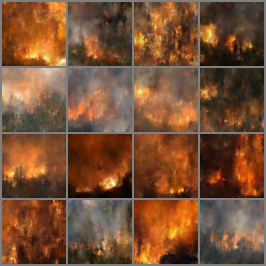



Sampling...

Sampling...


  0%|          | 0/500 [00:00<?, ?it/s]

In [ ]:

total_epochs = 801
try:
    val()
    demo()
    while epoch < total_epochs:
        print('Epoch', epoch)
        train()
        epoch += 1
        val()
        if epoch % 200 == 0:
            demo()
            save()
            generate_and_save_images()
        # save()
except KeyboardInterrupt:
    pass


# Plot and save loss curves
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Curves')
plt.legend()
plt.savefig('loss_curves.png')
plt.show()

In [ ]:
len(val_losses)

27

In [ ]:
!zip -r /content/generated_images_800.zip /content/generated_images_800/*.png

!rsync -r --progress "./generated_images_800.zip" "/content/drive/MyDrive/Diffusion/generated_images_800"

In [ ]:
!zip -r /content/generated_images_600.zip /content/generated_images_600/*.png

!rsync -r --progress "./generated_images_600.zip" "/content/drive/MyDrive/Diffusion/generated_images_600"

In [ ]:
!zip -r /content/generated_images_400.zip /content/generated_images_400/*.png

!rsync -r --progress "./generated_images_400.zip" "/content/drive/MyDrive/Diffusion/generated_images_400"

In [ ]:
!zip -r /content/generated_images_200.zip /content/generated_images_200/*.png

!rsync -r --progress "./generated_images_200.zip" "/content/drive/MyDrive/Diffusion/generated_images_200"

In [ ]:
num_sample = 100
generated_samples_m = demo_fid_samples(num_sample)


Sampling...


  0%|          | 0/500 [00:00<?, ?it/s]

In [ ]:
generated_samples_m[0].shape

torch.Size([3, 64, 64])

In [ ]:
generated_samples_m.shape

In [ ]:
from torchvision.utils import save_image


In [ ]:
# Loop through the batch and save each image
for i in range(generated_samples_m.size(0)):
    # Extract one image from the batch
    image = generated_samples_m[i]
    # Save the image using torchvision's save_image function
    save_image(image, f"/content/generated_images_800/image_{i}.png")

In [ ]:

concatenated_images = None
for images, labels in train_dl:
    if concatenated_images is None:
        concatenated_images = images
    else:
        concatenated_images = torch.cat((concatenated_images, images), dim=0)

In [ ]:
concatenated_images2 = torch.clamp(concatenated_images, 0, 1)

In [ ]:
directory = f"/content/original_images_clamped/"
if not os.path.exists(directory):
    os.makedirs(directory)

In [ ]:
# Loop through the batch and save each image
for i in range(concatenated_images2.size(0)):
    # Extract one image from the batch
    image = concatenated_images2[i]
    # Save the image using torchvision's save_image function
    filename = f"/content/original_images_clamped/image_{i}.png"
    TF.to_pil_image(image.cpu().add(1).div(2).clamp(0, 1)).save(filename)

In [ ]:
!zip -r /content/original_images_clamped.zip /content/original_images_clamped/*.png

!rsync -r --progress "./original_images_clamped.zip" "/content/drive/MyDrive/Diffusion/original_images_clamped"

In [ ]:
!zip -r /content/generated_images_801.zip /content/generated_images_801/*.png

!rsync -r --progress "./generated_images_801.zip" "/content/drive/MyDrive/Diffusion/generated_images_801"

In [ ]:
import glob

In [ ]:
all_images_list = []
for i in range(0,801,200):
  all_images_list.append('demo_{:05d}.png'.format(i))

In [ ]:
from PIL import Image, ImageDraw, ImageFont
import os

def add_text_to_image(image, text):
    draw = ImageDraw.Draw(image)
    font = ImageFont.load_default()
    text_width, text_height = draw.textsize(text, font)
    position = (image.width - text_width, 0)
    draw.text(position, text, fill='black', font=font)

In [ ]:
image_list = []
for file_name in all_images_list:
  image = Image.open(file_name)
  add_text_to_image(image, file_name)
  image_list.append(image)

In [ ]:
# Save the first image as a GIF file
image_list[0].save(
            'animation_faster_n.gif',
            save_all=True,
            append_images=image_list[1:], # append rest of the images
            duration=300, # in milliseconds
            loop=0)

In [ ]:
!rsync -r --progress "./animation_faster_n.gif" "/content/drive/My Drive/Diffusion/"

In [ ]:
!rsync -r --progress "./loss_curves.png" "/content/drive/My Drive/Diffusion/"

In [ ]:
!rsync -r --progress "./ddpm_forest_fire.pth" "/content/drive/My Drive/Diffusion/"

In [ ]:
!zip -r /content/model_checkpoints.zip /content/*.pth

!rsync -r --progress "./model_checkpoints.zip" "/content/drive/MyDrive/Diffusion/DDPM_checkpoints"

In [ ]:
!zip -r /content/epoch_output_images_n.zip /content/*.png

!rsync -r --progress "./epoch_output_images_n.zip" "/content/drive/MyDrive/Diffusion/DDPM_Epoch_Images"